In [25]:
import numpy as np 
import bagpipes as pipes

from astropy.io import fits
from PyAstronomy import pyasl
import sys
sys.path.append('/home/hin/Documents/St_Andrews/dense_basis')
import dense_basis as db

import matplotlib
import matplotlib.pyplot as plt

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70., Om0=0.3)
import pandas as pd
import os
import json

import sys
sys.path.append('..')
from code_bits.add_psbtwin import *
from code_bits.add_ceh_funcs import *

In [3]:
lines_air_df = pd.read_fwf('../skylines.txt')
lines_vac_sky = pyasl.airtovac2(lines_air_df[lines_air_df['flux']>=5]['wavelength'])

In [4]:
def bin(spectrum, binn):
    """ Bins up two or three column spectral data by a specified factor. """

    binn = int(binn)
    nbins = len(spectrum)/binn
    binspec = np.zeros((int(nbins), spectrum.shape[1]))

    for i in range(binspec.shape[0]):
        spec_slice = spectrum[i*binn:(i+1)*binn, :]
        binspec[i, 0] = np.mean(spec_slice[:, 0])
        binspec[i, 1] = np.mean(spec_slice[:, 1])

        if spectrum.shape[1] == 3:
            binspec[i,2] = (1./float(binn)
                            *np.sqrt(np.sum(spec_slice[:, 2]**2)))

    return binspec

def mask_sky(wave):
    """ Masks strong night sky emission lines that are often not removed 
    properly in the data processing. From masksky.pro """

    masksize=10
    lines_vac = lines_vac_sky #np.array([5578.5486,4279.2039,6301.7423,6365.7595])
    lines = pyasl.vactoair2(lines_vac)
    
    mask = []
    for i in range(lines.shape[0]):
        ind = np.where((wave>lines[i]-masksize) & (wave<lines[i]+masksize))
        mask.extend(ind[0])

    return mask

def mask_em(wave):
    """ from maskem.pro OII, Hgama, Hbeta, OIII, OIII: Vacuum """

    
    lines_vac = np.array([3727.092,3729.875,4102.892, 4341.692,4862.683,4960.295,5008.24,6564.61,6549.8490,6585.2784, 6717., 6731., 5893., 6302.046, 6918.6, 3870.])
    lines = pyasl.vactoair2(lines_vac)
    
    mask = []
    for i in range(lines.shape[0]):
        if lines[i] > 6500 and lines[i] < 6600 or lines[i]==5893:
            masksize = 10
        else:
            masksize = 5

        ind = np.where((wave>lines[i]-masksize) & (wave<lines[i]+masksize))
        mask.extend(ind[0])

    # MgII  2796.352 ,2803.531 
    #ind = np.where((wave>2766.4) & (wave<2833.5))

    # remove everything bluewards of 3000A
    #ind = np.where(wave<3000)
    #mask.extend(ind[0])    

    return mask

def load_manga_spec_mask(ID, full=False):
    """ Extracts correct spectrum and masks emission lines """
    """ Note redshift, flux etc. are all passed silently!!!!"""
   
    spectrum = np.loadtxt(fname=run_params['spectrum_dir']+
                          "/Spectrum_"+ID+".csv", delimiter=',', skiprows=1)
    
    spectrum[:,1] *= 10**-16
    spectrum[:,2] *= 10**-16

    # blow up the errors associated with any bad points in the spectrum and photometry
    for i in range(len(spectrum)):
        if spectrum[i,1] == 0 or spectrum[i,2] <= 0:
            spectrum[i,1] = 0.
            spectrum[i,2] = 9.9*10**99.
  
    # pixel mask from DAP, not clear if we want to use this or not. Try fort
    #pixmask = (np.where(mask[pix_x,pix_y,:] !=0))[0]
    #spectrum[pixmask, 2] = 9.9*10**99.


    # nebular emission lines and interstellar absorption lines
    linemask = mask_em(spectrum[:,0]/(1+z))
    spectrum[linemask, 2] = 9.9*10**99.
    
    # skylines
    linemask = mask_sky(spectrum[:,0])
    spectrum[linemask, 2] = 9.9*10**99.
  
    for j in range(len(spectrum)):
        if (spectrum[j, 1] == 0) or (spectrum[j, 2] <= 0):
            spectrum[j, 2] = 9.9*10**99.
    
    if full == False:
        endmask = (spectrum[:,0]/(1+z) < 7500) # just miles range
    else:
        endmask = (spectrum[:,0]>0)
    if run_params['bin_by'] == 1:
        return spectrum[endmask]
    else:
        return bin(spectrum[endmask], run_params['bin_by'])

def load_manga_photo_mask(ID):
    """ Reads spectrum csv and bins up the portion that corresponds to 7500-9500AA into one band """
    
    spectrum = np.loadtxt(fname=run_params['spectrum_dir']+
                          "/Spectrum_"+ID+".csv", delimiter=',', skiprows=1)
    spectrum = spectrum[np.where((spectrum[:,0]>7500) & (spectrum[:,0]<9500))]
    
    spectrum[:,1] *= 10**-16
    spectrum[:,2] *= 10**-16
    
    dlambda = pipes.utils.make_bins(spectrum[:,0])[1]
    tp = np.ones(len(spectrum[:,0]))
    weights = dlambda*tp
    eff_wave = np.sqrt(np.sum(weights)/np.sum(weights/spectrum[:,0]**2))
    #print(eff_wave)
    
    phot_flux = (np.sum(spectrum[:,0]*spectrum[:,1]*dlambda) / 
                 np.sum(spectrum[:,0]*dlambda)) / (10**-29*2.9979*10**18/eff_wave**2)
    phot_err = (np.sqrt(np.sum((spectrum[:,0]*dlambda*spectrum[:,2])**2)) / 
                np.sum(spectrum[:,0]*dlambda)) / (10**-29*2.9979*10**18/eff_wave**2)
    if phot_flux/phot_err>20:
        phot_err = phot_flux/15
    #print(phot_flux)
    #print(phot_err)
    
    return [[phot_flux, phot_err]] 

def load_manga_photo_mask_plot(ID):
    """ 
    difference: returns flux in erg/s/cm^2/AA, instead of converting it into mJy, also returns effective
    wavelength 
    """
    
    spectrum = np.loadtxt(fname=run_params['spectrum_dir']+
                          "/Spectrum_"+ID+".csv", delimiter=',', skiprows=1)
    spectrum = spectrum[np.where((spectrum[:,0]>7500) & (spectrum[:,0]<9500))]
    
    spectrum[:,1] *= 10**-16
    spectrum[:,2] *= 10**-16
    
    dlambda = pipes.utils.make_bins(spectrum[:,0])[1]
    tp = np.ones(len(spectrum[:,0]))
    weights = dlambda*tp
    eff_wave = np.sqrt(np.sum(weights)/np.sum(weights/spectrum[:,0]**2))
    #print(eff_wave)
    
    phot_flux = (np.sum(spectrum[:,0]*spectrum[:,1]*dlambda) / 
                 np.sum(spectrum[:,0]*dlambda))
    phot_err = (np.sqrt(np.sum((spectrum[:,0]*dlambda*spectrum[:,2])**2)) / 
                np.sum(spectrum[:,0]*dlambda))
    if phot_flux/phot_err>20:
        phot_err = phot_flux/15
    
    #print(phot_flux)
    #print(phot_err)
    
    return eff_wave, [phot_flux, phot_err]

def load_both(ID):
    spectrum = load_manga_spec_mask(ID)
    phot = load_manga_photo_mask(ID)

    return spectrum, phot

In [50]:
def make_fit_plot(fit, run_params):
    # Make the figure
    matplotlib.rcParams.update({'font.size': 16})
    params = {'legend.fontsize': 16,
              'legend.handlelength': 1}
    matplotlib.rcParams.update(params)
    matplotlib.rcParams['text.usetex'] = True
    fit.posterior.get_advanced_quantities()
    
    gal_ID = run_params['ID_plateifu']+run_params['data_file_extension']

    naxes=1
    fig = plt.figure(figsize=(15, 9.*naxes))

    gs1 = matplotlib.gridspec.GridSpec(5, 1, hspace=0., wspace=0.)
    ax1 = plt.subplot(gs1[:3])
    ax3 = plt.subplot(gs1[3])
    ax4 = plt.subplot(gs1[4])

    mask = fit.galaxy.spectrum[:, 2] < 1.
    masked_spec = np.where(fit.galaxy.spectrum[:,2]>1)[0]
    fit.galaxy.spectrum[mask, 2] = 0.

    y_scale = pipes.plotting.add_spectrum(fit.galaxy.spectrum, ax1, label='fitted obs spec')
    pipes.plotting.add_spectrum_posterior(fit, ax1, y_scale=y_scale)
    non_masked_obs_spec = np.delete(fit.galaxy.spectrum, masked_spec, axis=0)
    if ax1.get_ylim()[0] < 0.9*min(non_masked_obs_spec[:,1])*10**-y_scale:
        ax1.set_ylim(bottom=0.9*min(non_masked_obs_spec[:,1])*10**-y_scale)
    if ax1.get_ylim()[1] > 1.1*max(non_masked_obs_spec[:,1])*10**-y_scale:
        ax1.set_ylim(top=1.1*max(non_masked_obs_spec[:,1])*10**-y_scale)

    if 'noise' in fit.posterior.samples.keys():
        post_median = np.median(fit.posterior.samples["spectrum"]+fit.posterior.samples["noise"], axis=0)
    else:
        post_median = np.median(fit.posterior.samples["spectrum"], axis=0)

    #ax1.plot(fit.galaxy.spectrum[:,0],
    #         post_median*10**-y_scale,
    #         color="black", lw=1.0,zorder=11)

    #recover masks on spectrum and plot them as gray bands in residual plot
    mask_edges = [[masked_spec[0]],[]]
    for i,indi in enumerate(masked_spec[:-1]):
        if masked_spec[i+1] - indi > 1:
            mask_edges[1].append(indi)
            mask_edges[0].append(masked_spec[i+1])
    mask_edges[1].append(masked_spec[-1])
    mask_edges = np.array(mask_edges).T
    for [mask_min, mask_max] in mask_edges:
        ax3.fill_between([fit.galaxy.spectrum[:,0][mask_min], fit.galaxy.spectrum[:,0][mask_max]], 
                         [-10,-10], [10,10], color='lightgray', zorder=2)

    residuals = (fit.galaxy.spectrum[:,1] - post_median)*10**-y_scale
    non_masked_res = np.delete(residuals, masked_spec)
    ax3.axhline(0, color="black", ls="--", lw=1)
    ax3.plot(np.delete(fit.galaxy.spectrum[:,0], masked_spec), non_masked_res, color="sandybrown", zorder=1)
    #ax3.plot(fit.galaxy.spectrum[:,0], residuals, color="sandybrown",zorder=1)
    ax3.set_ylabel('residual')
    ax3.set_ylim([1.1*min(non_masked_res), 1.1*max(non_masked_res)])

    #extend posterior spectrum
    # Calculate posterior median redshift.
    if "redshift" in fit.fitted_model.params:
        redshift = np.median(fit.posterior.samples["redshift"])

    else:
        redshift = fit.fitted_model.model_components["redshift"]

    # Plot the posterior photometry and full spectrum.
    full_wavs = fit.posterior.model_galaxy.wavelengths*(1.+redshift)

    spec_post = np.percentile(fit.posterior.samples["spectrum_full"],
                              (16, 84), axis=0).T*10**-y_scale

    spec_post = spec_post.astype(float)  # fixes weird isfinite error

    ax1.plot(full_wavs, spec_post[:, 0], color="navajowhite",
            zorder=-1)

    ax1.plot(full_wavs, spec_post[:, 1], color="navajowhite",
            zorder=-1)

    ax1.fill_between(full_wavs, spec_post[:, 0], spec_post[:, 1],
                    zorder=-1, color="navajowhite", linewidth=0, 
                     label=r'post full spectrum(no noise) $\pm 1 \sigma$')

    full_spectrum = load_manga_spec_mask(gal_ID, full=True)
    ax1.plot(full_spectrum[:,0], full_spectrum[:,1]*10**-y_scale, color='b', alpha=0.2, zorder=-2, 
             label='non-fitted full obs spec')
    eff_wave, phot = load_manga_photo_mask_plot(gal_ID)
    ax1.errorbar(eff_wave, phot[0]*10**-y_scale,
                yerr=phot[1]*10**-y_scale, lw=1,
                linestyle=" ", capsize=3, capthick=1, zorder=0,
                color="black")

    ax1.scatter(eff_wave, phot[0]*10**-y_scale, color="blue",
               s=40, zorder=1, linewidth=1, facecolor="blue",
               edgecolor="black", marker="o", label='converted red-end photometry')

    if fit.galaxy.photometry_exists:
        text = 'photometric point fitted'
    else:
        text = 'photometric point NOT fitted'
    ax1.text(0.72,0.56, text, transform=ax1.transAxes)
    ax1.legend(loc='upper right')
    ax1.set_xlim([min(fit.galaxy.spectrum[:,0]),9500])
    ax3.set_xlim(ax1.get_xlim())

    # Plot the noise factor
    if 'noise' in fit.posterior.samples.keys():
        noise_percentiles = np.percentile(fit.posterior.samples['noise'],(16,50,84),axis=0)*10**-y_scale
        ax4.plot(fit.galaxy.spectrum[:,0], noise_percentiles[1],color="sandybrown", zorder=1)
        ax4.fill_between(fit.galaxy.spectrum[:,0], noise_percentiles[0], noise_percentiles[2], 
                         color='navajowhite', zorder=-1)
    ax4.axhline(0, color="black", ls="--", lw=1)

    ax4_ylims = ax4.get_ylim()
    for [mask_min, mask_max] in mask_edges:
        ax4.fill_between([fit.galaxy.spectrum[:,0][mask_min], fit.galaxy.spectrum[:,0][mask_max]], 
                         [-10,-10], [10,10], color='lightgray', zorder=2)
    ax4.set_xlim(ax1.get_xlim())
    ax4.set_ylim(ax4_ylims)
    pipes.plotting.auto_x_ticks(ax4)
    ax4.set_xlabel("$\\lambda / \\mathrm{\\AA}$")
    ax4.set_ylabel('noise')
    
    return fig, [ax1,ax3,ax4]

def integrate_sfh(ages, sfh, Mstar=None):
    """ 
    takes a sfh and integrates it to return a cumulative SFH (normalized to run from 0 to 1) fraction of 
    mass formed
    """
    if Mstar is None:
        Mstar = np.trapz(y=sfh,x=ages)
    c_sfh = np.zeros(len(sfh))
    for i,sfhi in enumerate(sfh):
        c_sfh[i] = np.trapz(sfh[:i+1],x=ages[:i+1]/Mstar)
    return c_sfh

def make_sfh_plot(fit, ID, runID, plot_mean=False, ninty_region=False, samples=0, save=True):
    """
    Plots the regular SFH (SFR vs age of universe) plot on the top, cumulative SFH plot on the bottom
    """
    post_z = np.median(fit.posterior.samples['redshift'])
    age_at_z = pipes.utils.cosmo.age(post_z).value
    
    #identify SFH component used
    if "psb2" in fit.fit_instructions.keys():
        SFH_comp = "psb2"
    elif "psb_wild2020" in fit.fit_instructions.keys():
        SFH_comp = "psb_wild2020"
    elif "psb_twin" in fit.fit_instructions.keys():
        SFH_comp = "psb_twin"
    
    #posterior sfh
    post_sfh = fit.posterior.samples['sfh']
    mean_sfh = np.mean(post_sfh,axis=0)
    age_of_universe = np.interp(post_z, pipes.utils.z_array, pipes.utils.age_at_z)
    post_ages = age_of_universe - fit.posterior.sfh.ages*10**-9
    post_ages_int = post_ages.copy()[::-1]*10**9
    
    #calculating cumulative posterior sfh, tx and their uncertainties
    mass_percentiles = np.linspace(0,1,5)[1:-1]
    txs = []
    c_sfh_samples = []
    for sfh_sample in fit.posterior.samples['sfh']:
        sfh_ = sfh_sample[::-1]
        c_sfh_ = integrate_sfh(post_ages_int, sfh_)
        c_sfh_samples.append(c_sfh_)
        txs.append(np.interp(mass_percentiles, c_sfh_, post_ages_int))
    txs = (np.array(txs)/10**9).T
    tx_percentiles = []
    for i,txi in enumerate(txs):
        tx_percentiles.append(np.percentile(txi, (16,50,84)))
    tx_percentiles = np.array(tx_percentiles)
    #print(tx_percentiles)
    c_sfh_percentiles = np.percentile(c_sfh_samples, (16,50,84), axis=0)
    c_sfh_mean = np.mean(c_sfh_samples, axis=0)
    
    ################# plotting 
    
    fig, ax = plt.subplots(2,1, figsize=[15,10])
    pipes.plotting.add_sfh_posterior(fit, ax[0], z_axis=False, zorder=9)
    if plot_mean:
        ax[0].plot(post_ages, mean_sfh, color='k', ls='--', zorder=7)
    if ninty_region:
        ninty_sfh = np.percentile(post_sfh, (5,95), axis=0)
        ax[0].fill_between(post_ages, ninty_sfh[0], ninty_sfh[1], color='gray', 
                           alpha=0.3, zorder=6)
    ylim = ax[0].get_ylim()
    
    #use psb2's built in fburst and tburst posteriors
    post_f_burst = np.percentile(fit.posterior.samples[SFH_comp+":fburst"], (16,50,84))
    post_t_burst = age_of_universe-np.percentile(fit.posterior.samples[SFH_comp+":burstage"], (84,50,16))
    post_Mstar = np.percentile(fit.posterior.samples['formed_mass'], (16,50,84))
    print('posterior f_burst and t_burst:',post_f_burst,post_t_burst)
    
    #add text about z, age at z, poster f_burst and t_burst
    f_burst_r = [np.round(post_f_burst[1],2),np.round(post_f_burst[2]-post_f_burst[1],2),
                 np.round(post_f_burst[1]-post_f_burst[0],2)]
    f_burst_text = f'f\_burst={f_burst_r[0]}+{f_burst_r[1]}-{f_burst_r[2]}\n '
    t_burst_r = [np.round(post_t_burst[1],2),np.round(post_t_burst[2]-post_t_burst[1],2),
                 np.round(post_t_burst[1]-post_t_burst[0],2)]
    t_burst_text = f't\_burst={t_burst_r[0]}+{t_burst_r[1]}-{t_burst_r[2]}Gyr \n '
    Mstar_r = [np.round(post_Mstar[1],2),np.round(post_Mstar[2]-post_Mstar[1],2),
                 np.round(post_Mstar[1]-post_Mstar[0],2)]
    Mstar_text = r"formed $\log_{10}M_*$=" + f'{Mstar_r[0]}+{Mstar_r[1]}-{Mstar_r[2]}'
    ax[0].text(0.03,0.6,
            f'redshift={np.round(post_z,3)}\n ' + 
            f'age at z={np.round(age_at_z,2)}Gyr\n ' + 
            f_burst_text + 
            t_burst_text +
            Mstar_text,
            fontsize=14, transform=ax[0].transAxes, bbox=dict(boxstyle='round', facecolor='white'), zorder=20)
    
    ax[0].set_xlim(ax[0].get_xlim()[::-1])
    pipes.plotting.add_z_axis(ax[0])
    
    ax[1].plot(post_ages[::-1], c_sfh_percentiles[1], color='k', zorder=8)
    if plot_mean:
        ax[1].plot(post_ages[::-1], c_sfh_mean, color='k', ls='--', zorder=6)
    ax[1].fill_between(post_ages[::-1], c_sfh_percentiles[0], c_sfh_percentiles[2], color='gray', 
                       alpha=0.6, zorder=7)
    if ninty_region:
        c_ninty_sfh = np.percentile(c_sfh_samples, (5,95), axis=0)
        ax[1].fill_between(post_ages[::-1], c_ninty_sfh[0], c_ninty_sfh[1], color='gray', 
                           alpha=0.3, zorder=5)
    ax[1].errorbar(tx_percentiles[:,1], np.linspace(0,1,5)[1:-1], xerr=[tx_percentiles[:,1]-tx_percentiles[:,0],
                                                                        tx_percentiles[:,2]-tx_percentiles[:,1]],
              color='red', label='calculated equivilent tx times (assuming 4 bins)', fmt='o', zorder=10)
    
    ax[1].set_xlim(ax[0].get_xlim())
    ax[1].set_ylim([0,1])
    ax[1].set_xlabel(ax[0].get_xlabel())
    ax[1].set_ylabel('fraction of cumulative mass formed')
    
    if samples > 0:
        samp_ind = np.random.randint(fit.posterior.n_samples, size=samples)
        for samp_i in samp_ind:
            ax[0].plot(post_ages, fit.posterior.samples['sfh'][samp_i], color='black', alpha=0.3, ls='--',
                       zorder=5)
            ax[1].plot(post_ages[::-1], c_sfh_samples[samp_i], color='black', alpha=0.3, ls='--', zorder=5)
    
    if save:
        fig.savefig('pipes/plots/'+runID+'/'+ID+'_combined_sfh.pdf')
    plt.show()
    
    return fig,ax
    

In [287]:
runID = '8083-12703_datacube_summed_PSBonly_P4_no_red_phot_dereddened_binby1_Rspec4340'

# recover the fit's posterior and run params
posterior_dir = 'pipes/posterior/'+runID
for filename in os.listdir(posterior_dir):
    if '.json' in filename:
        json_file = filename
run_params = json.load(open(posterior_dir+'/'+json_file,'r'))
print(run_params)

pipes.config.R_spec = run_params['Rspec']
ID_plateifu = run_params['ID_plateifu']
z = run_params['z']
gal_ID = ID_plateifu+run_params['data_file_extension']
if run_params['red_phot']:
    galaxy = pipes.galaxy(gal_ID, load_both, photometry_exists=True, filt_list=["filters/red_end.txt"])
else:
    galaxy = pipes.galaxy(gal_ID, load_manga_spec_mask, photometry_exists=False)
    
fit = pipes.fit(galaxy, {}, run=run_params['runID'])

{'ID_plateifu': '8083-12703', 'data_file_extension': '_PSBonly_dereddened', 'bin_by': 1, 'spectrum_dir': 'MaNGA_spectrums', 'runID': '8083-12703_datacube_summed_PSBonly_P4_no_red_phot_dereddened_binby1_Rspec4340', 'Rspec': 4340, 'red_phot': False, 'GP': True, 'z': 0.0243398}

Results loaded from pipes/posterior/8083-12703_datacube_summed_PSBonly_P4_no_red_phot_dereddened_binby1_Rspec4340/8083-12703_PSBonly_dereddened.h5



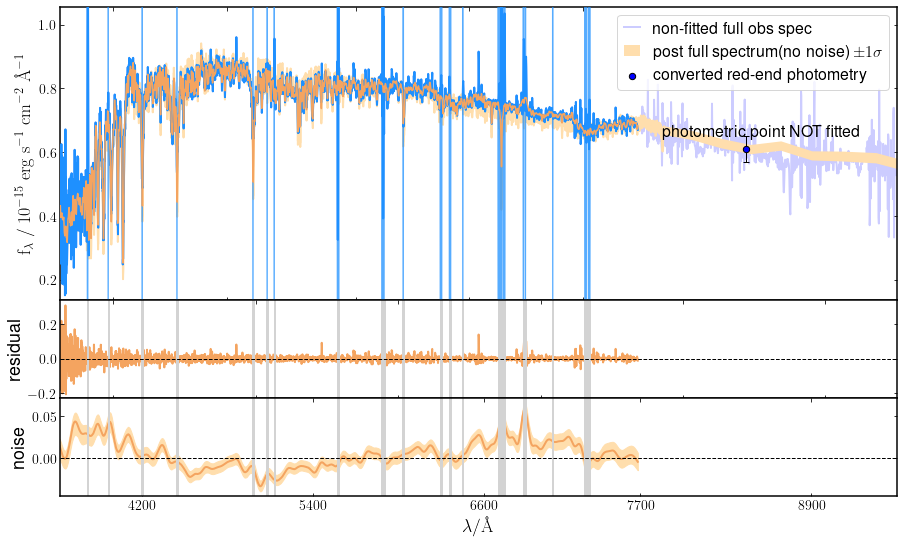

In [288]:
fig, axes = make_fit_plot(fit, run_params)

#for axi in axes:
#    axi.set_xlim([7700,8400])
#pipes.plotting.auto_x_ticks(axes[-1])
fig.savefig('pipes/plots/'+run_params['runID']+'/'+gal_ID+'_fit.pdf')
plt.show()

In [289]:
fig = fit.plot_sfh_posterior(save=True, show=True)
fig = fit.plot_corner(save=True, show=True)

posterior f_burst and t_burst: [0.22506424 0.31159096 0.43636005] [11.84436443 12.01169757 12.18107356]


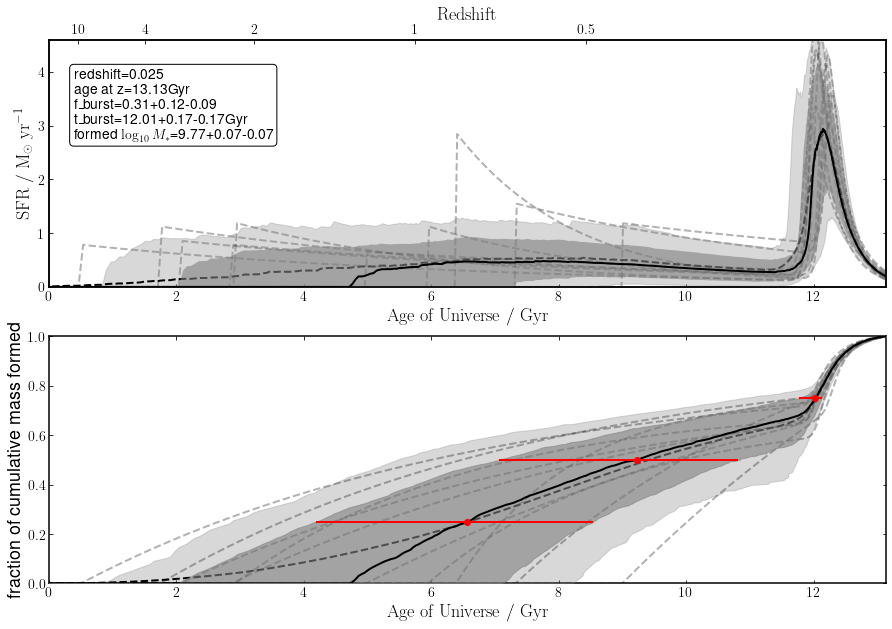

(<Figure size 1080x720 with 3 Axes>,
 array([<AxesSubplot:xlabel='$\\mathrm{Age\\ of\\ Universe\\ /\\ Gyr}$', ylabel='$\\mathrm{SFR\\ /\\ M_\\odot\\ \\mathrm{yr}^{-1}}$'>,
        <AxesSubplot:xlabel='$\\mathrm{Age\\ of\\ Universe\\ /\\ Gyr}$', ylabel='fraction of cumulative mass formed'>],
       dtype=object))

In [290]:
make_sfh_plot(fit, gal_ID, runID, save=True, plot_mean=True, ninty_region=True, samples=10)

{'data_file_extension': '_SNR15_dereddened', 'bin_by': 3, 'spectrum_dir': 'MaNGA_spectrums', 'runID_extension': '_datacube_summed_P9_no_red_phot_dereddened_binby3_Rspec1800', 'Rspec': 1800, 'red_phot': False, 'GP': True, 'ID_plateifu': '9507-12704', 'runID': '9507-12704_datacube_summed_P9_no_red_phot_dereddened_binby3_Rspec1800', 'z': 0.018702}

Results loaded from pipes/posterior/9507-12704_datacube_summed_P9_no_red_phot_dereddened_binby3_Rspec1800/9507-12704_SNR15_dereddened.h5



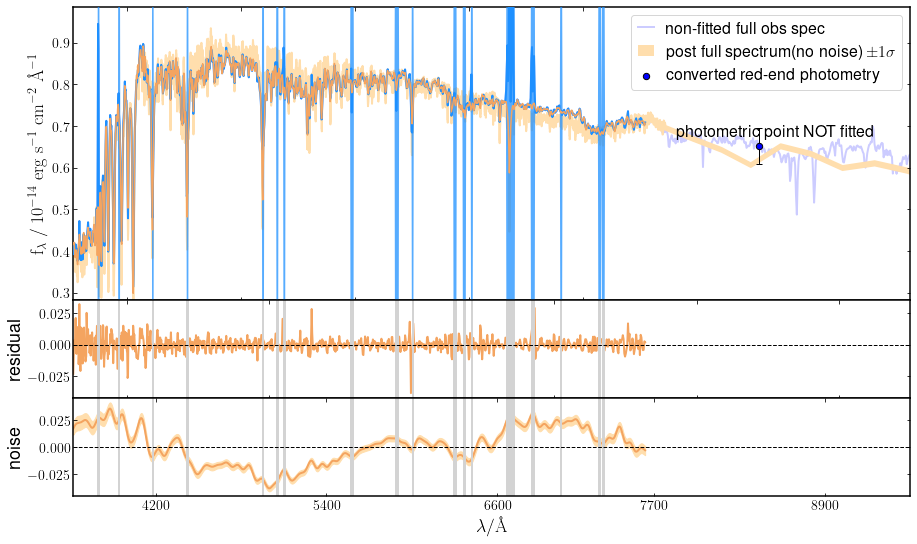

{'data_file_extension': '_SNR15_dereddened', 'bin_by': 3, 'spectrum_dir': 'MaNGA_spectrums', 'runID_extension': '_datacube_summed_P9_no_red_phot_dereddened_binby3_Rspec1800', 'Rspec': 1800, 'red_phot': False, 'GP': True, 'ID_plateifu': '8655-1902', 'runID': '8655-1902_datacube_summed_P9_no_red_phot_dereddened_binby3_Rspec1800', 'z': 0.0219618}

Results loaded from pipes/posterior/8655-1902_datacube_summed_P9_no_red_phot_dereddened_binby3_Rspec1800/8655-1902_SNR15_dereddened.h5



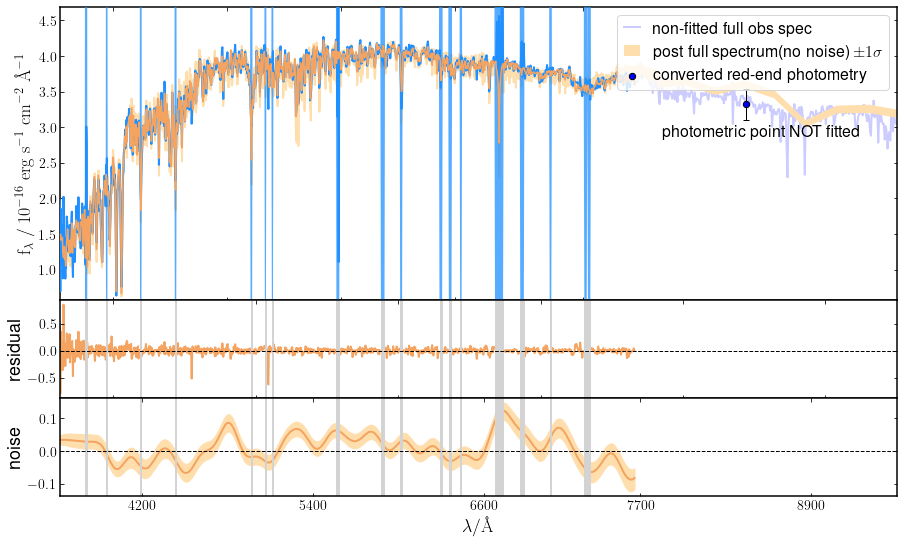

{'data_file_extension': '_SNR15_dereddened', 'bin_by': 3, 'spectrum_dir': 'MaNGA_spectrums', 'runID_extension': '_datacube_summed_P9_no_red_phot_dereddened_binby3_Rspec1800', 'Rspec': 1800, 'red_phot': False, 'GP': True, 'ID_plateifu': '9494-3701', 'runID': '9494-3701_datacube_summed_P9_no_red_phot_dereddened_binby3_Rspec1800', 'z': 0.0152525}

Results loaded from pipes/posterior/9494-3701_datacube_summed_P9_no_red_phot_dereddened_binby3_Rspec1800/9494-3701_SNR15_dereddened.h5



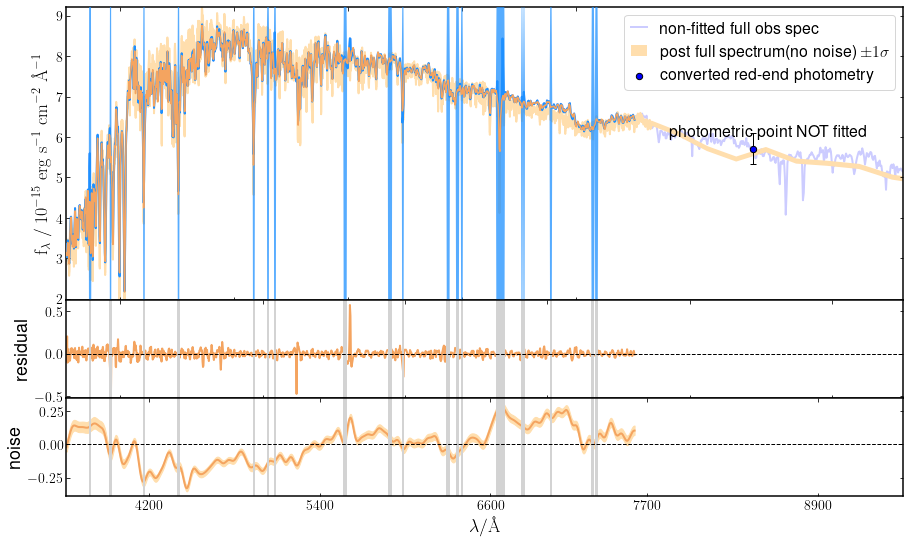

{'data_file_extension': '_SNR15_dereddened', 'bin_by': 3, 'spectrum_dir': 'MaNGA_spectrums', 'runID_extension': '_datacube_summed_P9_no_red_phot_dereddened_binby3_Rspec1800', 'Rspec': 1800, 'red_phot': False, 'GP': True, 'ID_plateifu': '8941-3701', 'runID': '8941-3701_datacube_summed_P9_no_red_phot_dereddened_binby3_Rspec1800', 'z': 0.0279985}

Results loaded from pipes/posterior/8941-3701_datacube_summed_P9_no_red_phot_dereddened_binby3_Rspec1800/8941-3701_SNR15_dereddened.h5



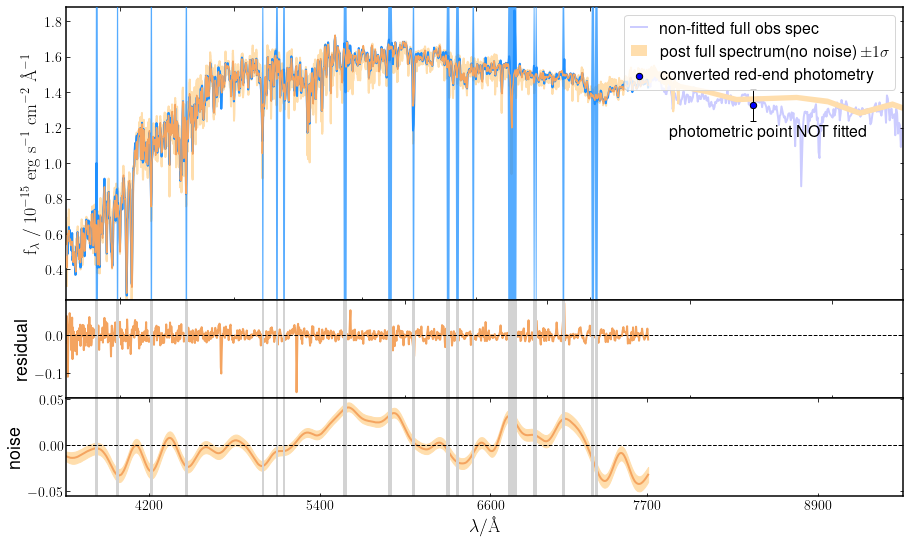

{'data_file_extension': '_SNR15_dereddened', 'bin_by': 3, 'spectrum_dir': 'MaNGA_spectrums', 'runID_extension': '_datacube_summed_P9_no_red_phot_dereddened_binby3_Rspec1800', 'Rspec': 1800, 'red_phot': False, 'GP': True, 'ID_plateifu': '9194-3702', 'runID': '9194-3702_datacube_summed_P9_no_red_phot_dereddened_binby3_Rspec1800', 'z': 0.0741421}

Results loaded from pipes/posterior/9194-3702_datacube_summed_P9_no_red_phot_dereddened_binby3_Rspec1800/9194-3702_SNR15_dereddened.h5



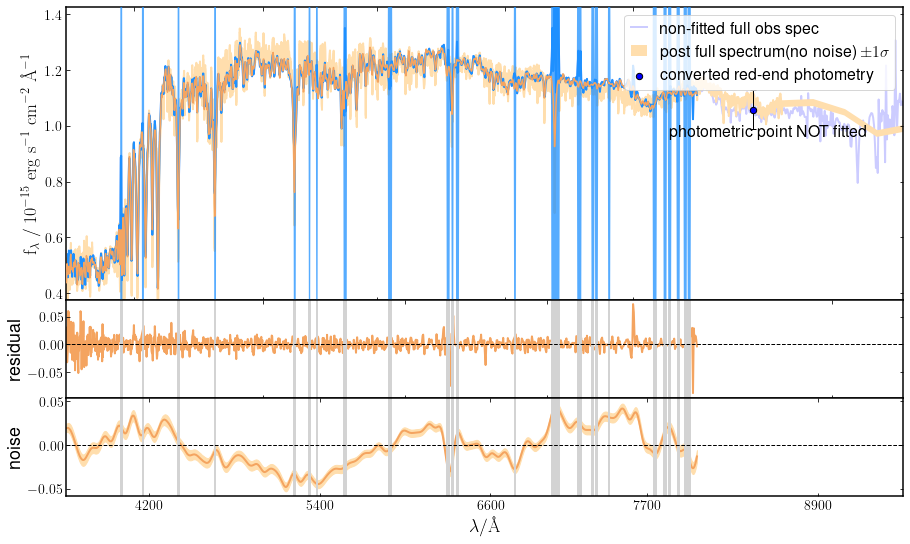

{'data_file_extension': '_SNR15_dereddened', 'bin_by': 3, 'spectrum_dir': 'MaNGA_spectrums', 'runID_extension': '_datacube_summed_P9_no_red_phot_dereddened_binby3_Rspec1800', 'Rspec': 1800, 'red_phot': False, 'GP': True, 'ID_plateifu': '8939-3703', 'runID': '8939-3703_datacube_summed_P9_no_red_phot_dereddened_binby3_Rspec1800', 'z': 0.021392}

Results loaded from pipes/posterior/8939-3703_datacube_summed_P9_no_red_phot_dereddened_binby3_Rspec1800/8939-3703_SNR15_dereddened.h5



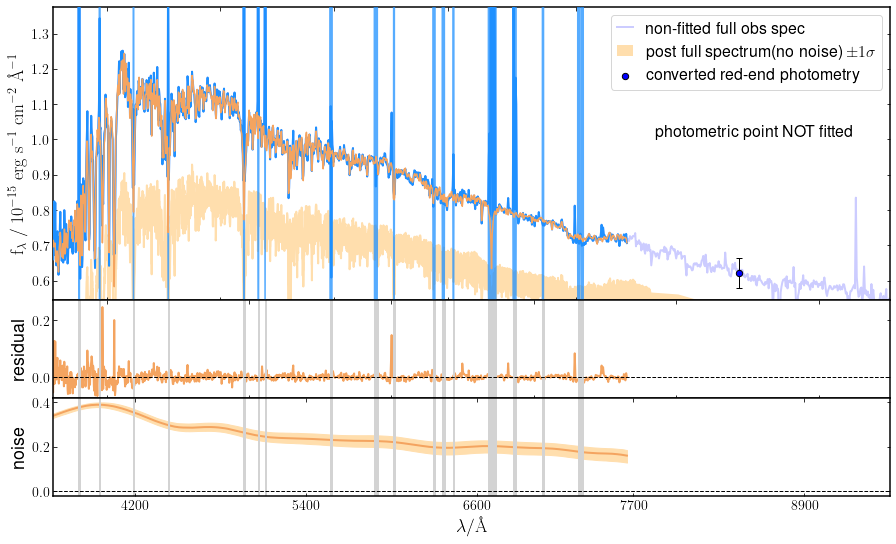

{'data_file_extension': '_SNR15_dereddened', 'bin_by': 3, 'spectrum_dir': 'MaNGA_spectrums', 'runID_extension': '_datacube_summed_P9_no_red_phot_dereddened_binby3_Rspec1800', 'Rspec': 1800, 'red_phot': False, 'GP': True, 'ID_plateifu': '8080-3704', 'runID': '8080-3704_datacube_summed_P9_no_red_phot_dereddened_binby3_Rspec1800', 'z': 0.02145}

Results loaded from pipes/posterior/8080-3704_datacube_summed_P9_no_red_phot_dereddened_binby3_Rspec1800/8080-3704_SNR15_dereddened.h5



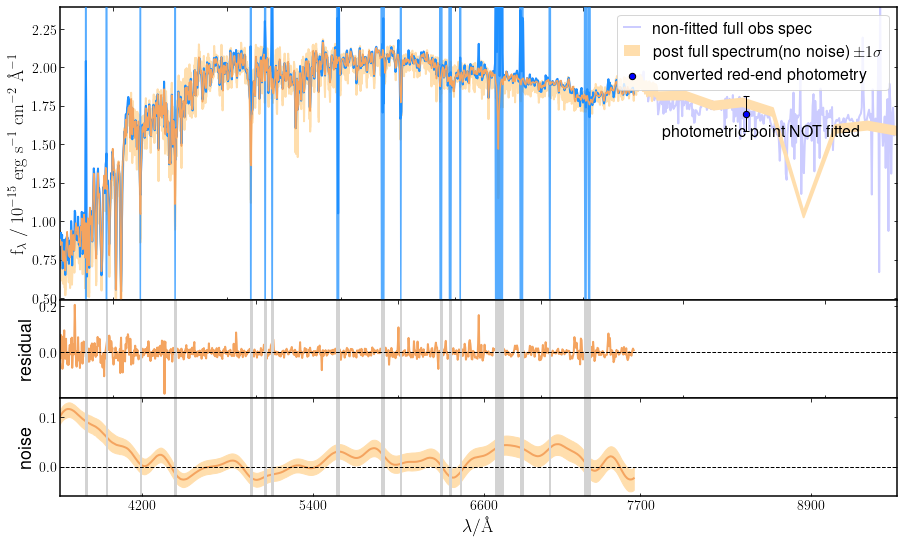

{'data_file_extension': '_SNR15_dereddened', 'bin_by': 3, 'spectrum_dir': 'MaNGA_spectrums', 'runID_extension': '_datacube_summed_P9_no_red_phot_dereddened_binby3_Rspec1800', 'Rspec': 1800, 'red_phot': False, 'GP': True, 'ID_plateifu': '8086-3704', 'runID': '8086-3704_datacube_summed_P9_no_red_phot_dereddened_binby3_Rspec1800', 'z': 0.040191}

Results loaded from pipes/posterior/8086-3704_datacube_summed_P9_no_red_phot_dereddened_binby3_Rspec1800/8086-3704_SNR15_dereddened.h5



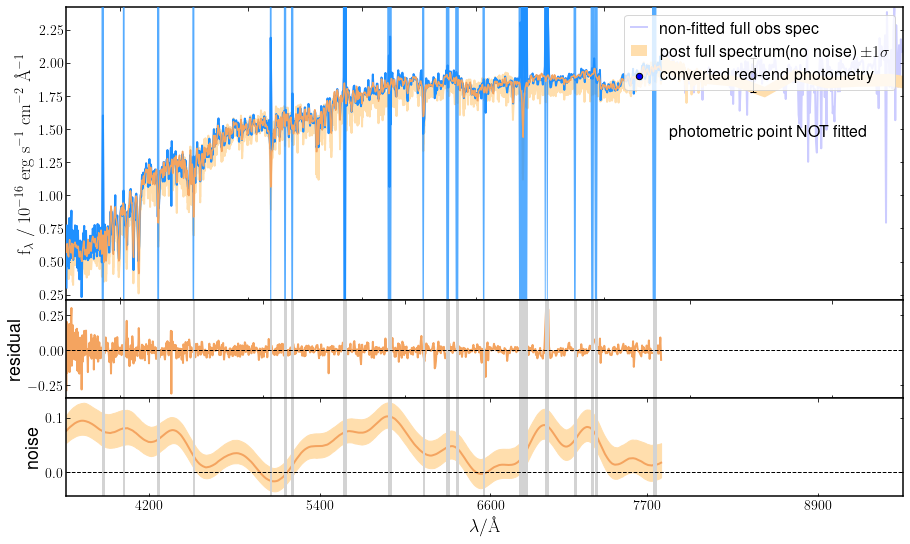

{'data_file_extension': '_SNR15_dereddened', 'bin_by': 3, 'spectrum_dir': 'MaNGA_spectrums', 'runID_extension': '_datacube_summed_P9_no_red_phot_dereddened_binby3_Rspec1800', 'Rspec': 1800, 'red_phot': False, 'GP': True, 'ID_plateifu': '9088-9102', 'runID': '9088-9102_datacube_summed_P9_no_red_phot_dereddened_binby3_Rspec1800', 'z': 0.0778585}

Results loaded from pipes/posterior/9088-9102_datacube_summed_P9_no_red_phot_dereddened_binby3_Rspec1800/9088-9102_SNR15_dereddened.h5



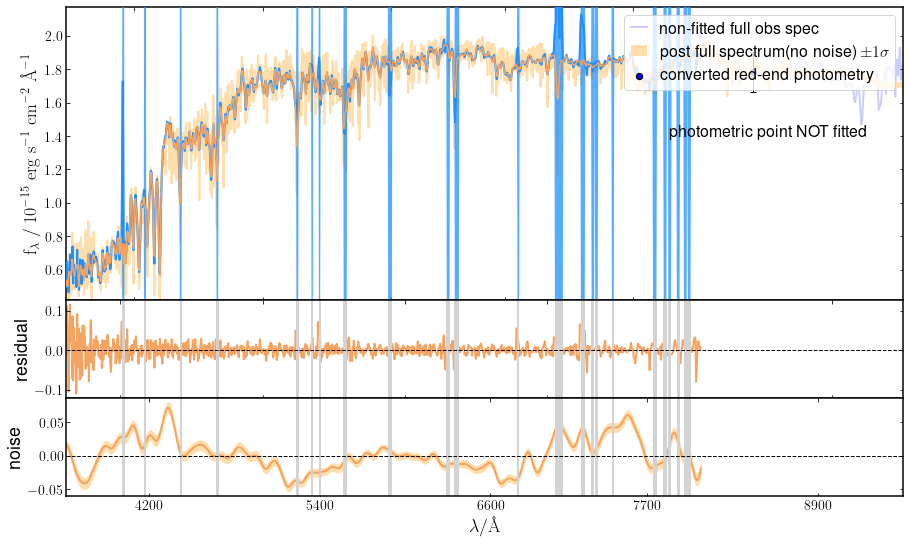

{'data_file_extension': '_SNR15_dereddened', 'bin_by': 3, 'spectrum_dir': 'MaNGA_spectrums', 'runID_extension': '_datacube_summed_P9_no_red_phot_dereddened_binby3_Rspec1800', 'Rspec': 1800, 'red_phot': False, 'GP': True, 'ID_plateifu': '7964-1902', 'runID': '7964-1902_datacube_summed_P9_no_red_phot_dereddened_binby3_Rspec1800', 'z': 0.0241526}

Results loaded from pipes/posterior/7964-1902_datacube_summed_P9_no_red_phot_dereddened_binby3_Rspec1800/7964-1902_SNR15_dereddened.h5



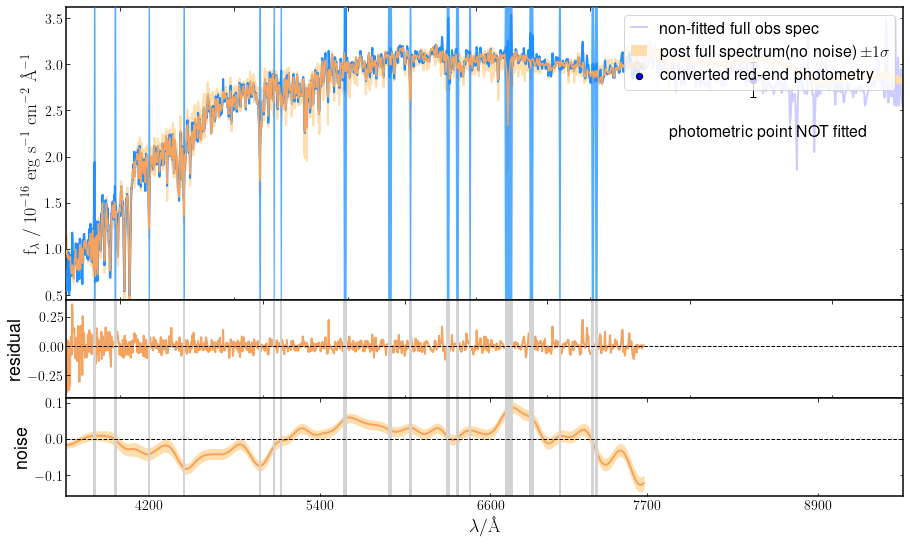

{'data_file_extension': '_SNR15_dereddened', 'bin_by': 3, 'spectrum_dir': 'MaNGA_spectrums', 'runID_extension': '_datacube_summed_P9_no_red_phot_dereddened_binby3_Rspec1800', 'Rspec': 1800, 'red_phot': False, 'GP': True, 'ID_plateifu': '8081-3702', 'runID': '8081-3702_datacube_summed_P9_no_red_phot_dereddened_binby3_Rspec1800', 'z': 0.0246549}

Results loaded from pipes/posterior/8081-3702_datacube_summed_P9_no_red_phot_dereddened_binby3_Rspec1800/8081-3702_SNR15_dereddened.h5



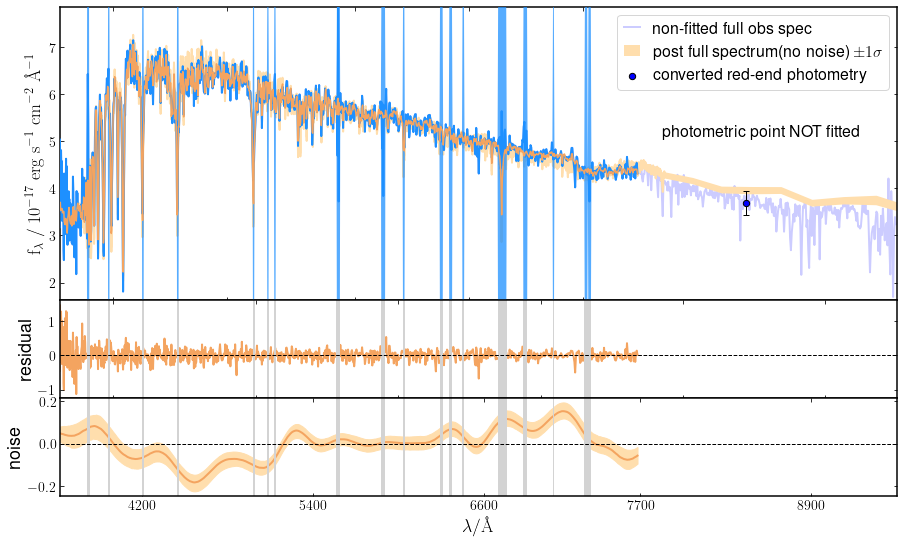

{'data_file_extension': '_SNR15_dereddened', 'bin_by': 3, 'spectrum_dir': 'MaNGA_spectrums', 'runID_extension': '_datacube_summed_P9_no_red_phot_dereddened_binby3_Rspec1800', 'Rspec': 1800, 'red_phot': False, 'GP': True, 'ID_plateifu': '8083-12703', 'runID': '8083-12703_datacube_summed_P9_no_red_phot_dereddened_binby3_Rspec1800', 'z': 0.0243398}

Results loaded from pipes/posterior/8083-12703_datacube_summed_P9_no_red_phot_dereddened_binby3_Rspec1800/8083-12703_SNR15_dereddened.h5



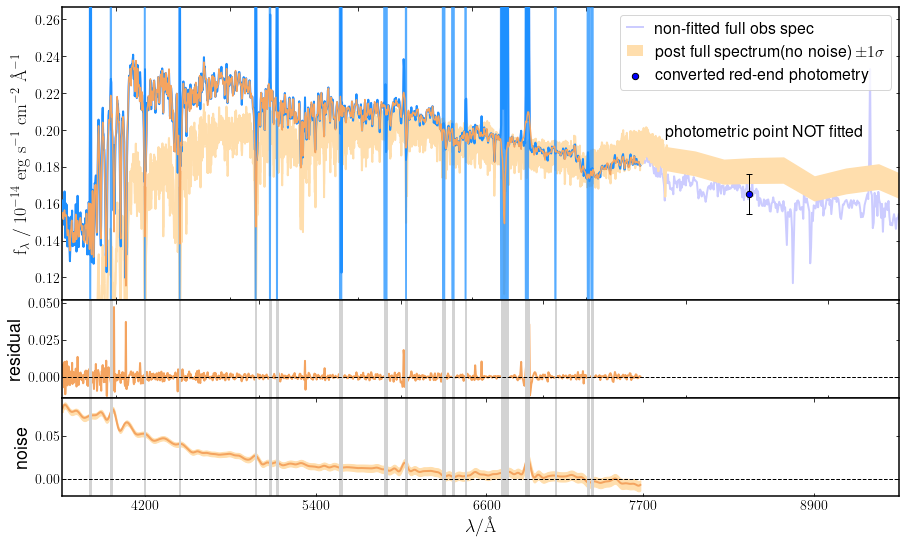

{'data_file_extension': '_SNR15_dereddened', 'bin_by': 3, 'spectrum_dir': 'MaNGA_spectrums', 'runID_extension': '_datacube_summed_P9_no_red_phot_dereddened_binby3_Rspec1800', 'Rspec': 1800, 'red_phot': False, 'GP': True, 'ID_plateifu': '8085-6104', 'runID': '8085-6104_datacube_summed_P9_no_red_phot_dereddened_binby3_Rspec1800', 'z': 0.020425}

Results loaded from pipes/posterior/8085-6104_datacube_summed_P9_no_red_phot_dereddened_binby3_Rspec1800/8085-6104_SNR15_dereddened.h5



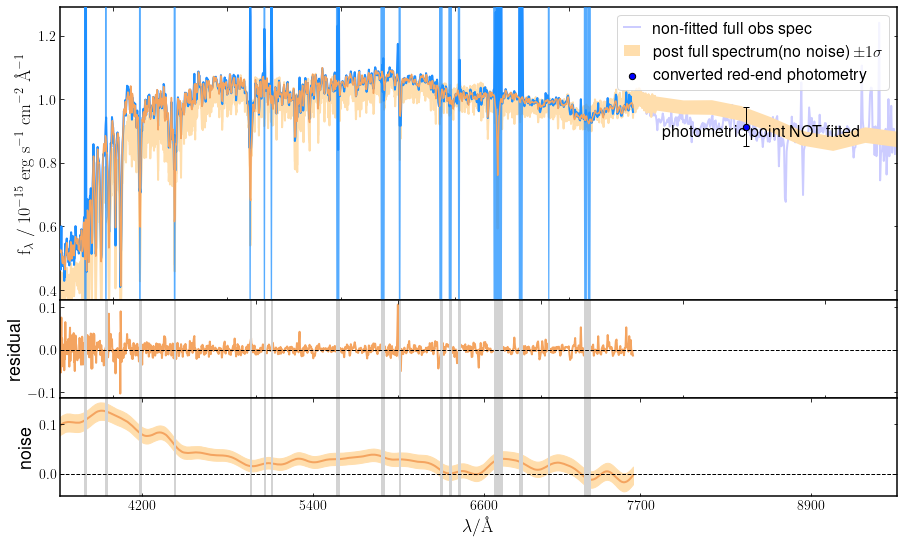

{'data_file_extension': '_SNR15_dereddened', 'bin_by': 3, 'spectrum_dir': 'MaNGA_spectrums', 'runID_extension': '_datacube_summed_P9_no_red_phot_dereddened_binby3_Rspec1800', 'Rspec': 1800, 'red_phot': False, 'GP': True, 'ID_plateifu': '8982-6104', 'runID': '8982-6104_datacube_summed_P9_no_red_phot_dereddened_binby3_Rspec1800', 'z': 0.0352905}

Results loaded from pipes/posterior/8982-6104_datacube_summed_P9_no_red_phot_dereddened_binby3_Rspec1800/8982-6104_SNR15_dereddened.h5



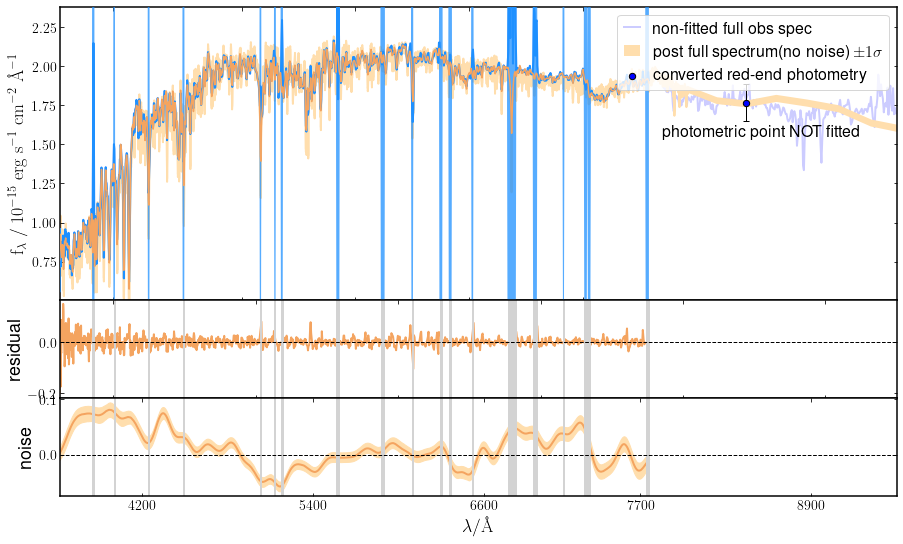

{'data_file_extension': '_SNR15_dereddened', 'bin_by': 3, 'spectrum_dir': 'MaNGA_spectrums', 'runID_extension': '_datacube_summed_P9_no_red_phot_dereddened_binby3_Rspec1800', 'Rspec': 1800, 'red_phot': False, 'GP': True, 'ID_plateifu': '8655-3701', 'runID': '8655-3701_datacube_summed_P9_no_red_phot_dereddened_binby3_Rspec1800', 'z': 0.0711797}

Results loaded from pipes/posterior/8655-3701_datacube_summed_P9_no_red_phot_dereddened_binby3_Rspec1800/8655-3701_SNR15_dereddened.h5



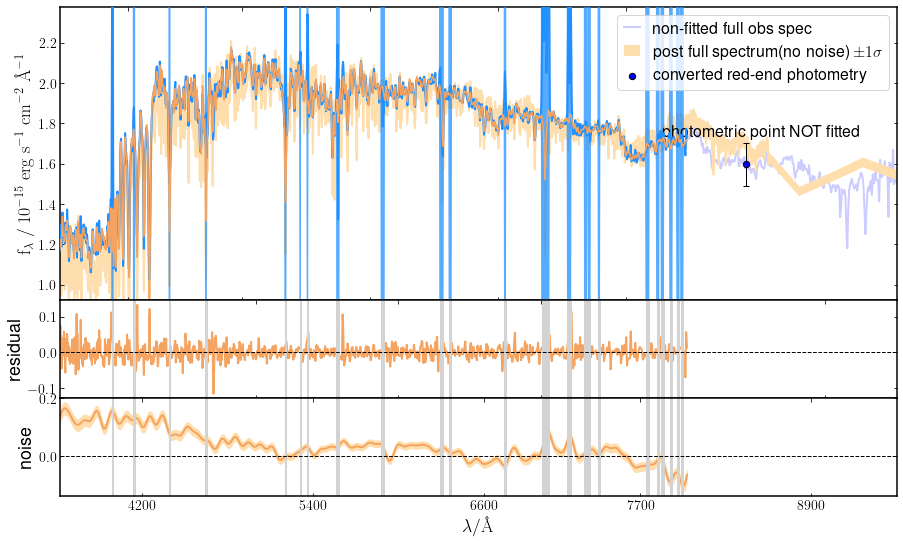

In [12]:
# auto run
targets = pd.read_fwf('PSBs_ALMAobs_sample.txt')
all_plateifu = targets['plateifu']
for i,ID_plateifu in enumerate(all_plateifu):
    
    runID = ID_plateifu + '_datacube_summed_P9_no_red_phot_dereddened_binby3_Rspec1800'

    # recover the fit's posterior and run params
    posterior_dir = 'pipes/posterior/'+runID
    for filename in os.listdir(posterior_dir):
        if '.json' in filename:
            json_file = filename
    run_params = json.load(open(posterior_dir+'/'+json_file,'r'))
    print(run_params)

    pipes.config.R_spec = run_params['Rspec']
    #ID_plateifu = run_params['ID_plateifu']
    z = run_params['z']
    gal_ID = ID_plateifu+run_params['data_file_extension']
    if run_params['red_phot']:
        galaxy = pipes.galaxy(gal_ID, load_both, photometry_exists=True, filt_list=["filters/red_end.txt"])
    else:
        galaxy = pipes.galaxy(gal_ID, load_manga_spec_mask, photometry_exists=False)

    fit = pipes.fit(galaxy, {}, run=run_params['runID'])
    
    fig, axes = make_fit_plot(fit, run_params)
    fig.savefig('pipes/plots/'+run_params['runID']+'/'+gal_ID+'_fit.pdf')
    plt.show()
    
    fig = fit.plot_sfh_posterior(save=True, show=True)
    fig = fit.plot_corner(save=True, show=True)

## Comparison between different fitting models/sets of models
Use violin plots to show differences, requires calculating everything relatated to SFH<br>
plot should be adaptive to: number of models compared, number of properties compared

In [295]:
class bagpipes_result:
    def __init__(self, runID):
        ID_plateifu = runID.split('_')[0]
        self.ID = ID_plateifu
        
        print('runID =', runID)

        # recover the fit's posterior and run params
        posterior_dir = 'pipes/posterior/'+runID
        for filename in os.listdir(posterior_dir):
            if '.json' in filename:
                json_file = filename
        run_params = json.load(open(posterior_dir+'/'+json_file,'r'))

        pipes.config.R_spec = run_params['Rspec']
        #z = run_params['z']
        gal_ID = ID_plateifu+run_params['data_file_extension']
        if run_params['red_phot']:
            galaxy = pipes.galaxy(gal_ID, load_both, photometry_exists=True, filt_list=["filters/red_end.txt"])
        else:
            galaxy = pipes.galaxy(gal_ID, load_manga_spec_mask, photometry_exists=False)

        self.fit = pipes.fit(galaxy, {}, run=run_params['runID'])
        self.samples = self.fit.posterior.samples
        
        post_z = np.median(self.samples['redshift'])
        self.age_at_z = cosmo.age(post_z).value
        
        #posterior sfh
        self.post_sfh = self.samples['sfh']
        self.age_of_universe = np.interp(post_z, pipes.utils.z_array, pipes.utils.age_at_z)
        self.post_ages = self.age_of_universe - self.fit.posterior.sfh.ages*10**-9
        
        #identify SFH component used
        if "psb2" in self.fit.fit_instructions.keys():
            self.SFH_comp = "psb2"
        elif "psb_wild2020" in self.fit.fit_instructions.keys():
            self.SFH_comp = "psb_wild2020"
        elif "psb_twin" in self.fit.fit_instructions.keys():
            self.SFH_comp = "psb_twin"
        
    def Mstar(self):
        Mstar_key = 'formed_mass'
        self.post_Mstar_ = self.samples[Mstar_key]
        post_Mstar = np.percentile(self.post_Mstar_, (16,50,84))

        print('posterior Mstar =', post_Mstar)
        
    def f_t_burst(self):
        #use psb2's built in fburst and tburst posteriors
        self.post_f_burst_ = self.samples[self.SFH_comp+':fburst']
        self.post_t_burst_ = self.age_of_universe-self.samples[self.SFH_comp+':burstage']
        post_f_burst = np.percentile(self.post_f_burst_, (16,50,84))
        post_t_burst = np.percentile(self.post_t_burst_, (84,50,16))

        print('posterior f_burst and t_burst:',post_f_burst,post_t_burst)
        
    def cal_f_gyr(self, ages, sfh, duration):
        # calculating the fractional mass formed in the most recent x Gyr 
        # defined in "duration"
        age_of_universe = max(ages)
        m_total = np.trapz(y=sfh[::-1], x=ages[::-1])
        recent_sfh = sfh[ages>=(age_of_universe-duration)]
        recent_ages = ages[ages>=(age_of_universe-duration)]
        m_recent = np.trapz(y=recent_sfh[::-1], x=recent_ages[::-1])
        return m_recent/m_total
    
    def f_gyr(self):
        # fraction of mass formed in the last 1 and 1.5 Gyr
        self.post_f10_ = np.zeros(len(self.post_sfh))
        self.post_f15_ = np.zeros(len(self.post_sfh))
        for i,sfh in enumerate(self.post_sfh):
            self.post_f10_[i] = self.cal_f_gyr(self.post_ages, sfh, 1)
            self.post_f15_[i] = self.cal_f_gyr(self.post_ages, sfh, 1.5)
        post_f10 = np.percentile(self.post_f10_, (16,50,84))
        post_f15 = np.percentile(self.post_f15_, (16,50,84))
        print('posterior fractions = ',post_f10,post_f15)
        
    def cal_tquench(self, lb_time, sfh, plot=False):
        logage_lhs = pipes.utils.make_bins(np.log10(lb_time), make_rhs=True)[0]
        age_lhs = 10**(logage_lhs)
        age_lhs[0] = 0.
        hubble_time = pipes.utils.age_at_z[pipes.utils.z_array == 0.]
        age_lhs[-1] = 10**9*hubble_time
        age_widths = age_lhs[1:] - age_lhs[:-1]
        tH = (cosmo.age(0.04).value-lb_time)*10**9

        ind_2gyr = (np.where(lb_time < 2))[0]

        ssfr = sfh/np.flip(np.cumsum(np.flip(sfh*age_widths*10**9,0)),0)
        if len(np.where(ssfr>0.2/tH)[0]) !=0:
            t1 = tH[(np.where(ssfr>0.2/tH))[0][0]]
        if len(np.where(ssfr>1/tH)[0]) !=0:
            t2 = tH[(np.where(ssfr>1/tH))[0][0]]
        t3 = tH[(np.where(ssfr == np.max(ssfr[ind_2gyr])))[0][0]]

        if t1>0 and t2>0:
            tquench_from_1 = (t1-t2)*10**-9
        if t1>0:
            tquench_from_peak = (t1-t3)*10**-9
        if t2<t3:
            tquench_from_1 = tquench_from_peak = np.nan

        if plot==True:
            fig,ax = plt.subplots(figsize=[15,6])
            ax.plot(tH*10**-9,np.log10(ssfr),marker='^')
            ax.plot(tH*10**-9,np.log10(1/tH))
            ax.plot(tH*10**-9,np.log10(0.2/tH))
            ax.vlines(np.array([t1,t2,t3])*10**-9, *ax.get_ylim(), color='k', ls='--')
            ax.set_xlim(cosmo.age(0.04).value, 0.)
            ax.set_xlabel('Age of Universe / Gyr')
            ax.set_ylabel('sSFR')
            plt.show()

        return tquench_from_1,tquench_from_peak
    
    def tquench(self, plot=True):
        #--- age bins ---
        sfh_ages = self.fit.posterior.sfh.ages*10**-9
        logage_lhs = pipes.utils.make_bins(np.log10(sfh_ages), make_rhs=True)[0]
        age_lhs = 10**(logage_lhs)
        age_lhs[0] = 0.
        hubble_time = pipes.utils.age_at_z[pipes.utils.z_array == 0.]
        age_lhs[-1] = 10**9*hubble_time
        age_widths = age_lhs[1:] - age_lhs[:-1]

        ind_2gyr = (np.where(self.fit.posterior.sfh.ages < 2*10**9))[0]

        nsamp = self.samples["sfh"].shape[0]
        ssfr = np.zeros((nsamp,len(sfh_ages)))
        t1 = np.zeros(nsamp)
        t2 = np.zeros(nsamp)
        t3 = np.zeros(nsamp)
        tH = (self.fit.posterior.sfh.age_of_universe-self.fit.posterior.sfh.ages)


        for k in range(nsamp):
            ssfr[k,:] = self.samples["sfh"][k,:] / \
                np.flip(np.cumsum(np.flip(
                    self.samples["sfh"][k,:]*age_widths*10**9,0
                )),0)
            if len(np.where(ssfr[k,:]>0.2/tH)[0]) !=0:
                t1[k] = tH[(np.where(ssfr[k,:]>0.2/tH))[0][0]]
            if len(np.where(ssfr[k,:]>1/tH)[0]) !=0:
                t2[k] = tH[(np.where(ssfr[k,:]>1/tH))[0][0]]
            t3[k] = tH[(np.where(ssfr[k,:] == np.max(ssfr[k,ind_2gyr])))[0][0]] 

        # just for plotting
        post_ssfr = np.percentile(ssfr,(16,50,84),axis=0).T

        #--- quenching timescales ----
        ind = (np.where((t1>0) & (t2>0)))[0]
        self.post_tquench_from_1_ = (t1[ind]-t2[ind])*10**-9
        tquench_from_1 = np.percentile(self.post_tquench_from_1_,(16,50,84))
        ind = (np.where(t1>0))[0]
        self.post_tquench_from_peak_ = (t1[ind]-t3[ind])*10**-9
        tquench_from_peak = np.percentile(self.post_tquench_from_peak_,(16,50,84))
        if np.median(t2)<np.median(t3):
            tquench_from_1 = tquench_from_peak = np.nan

        print('post tquench from peak = ',tquench_from_peak)
        print('post tquench from 1 = ',tquench_from_1)
        
        if plot == True:
            fig,ax = plt.subplots(figsize=[15,6])
            ax.plot(tH*10**-9,np.log10(np.median(ssfr,axis=0)))
            ax.plot(tH*10**-9,np.log10(1/tH))
            ax.plot(tH*10**-9,np.log10(0.2/tH))
            ax.vlines(np.array([np.median(t1),np.median(t2),np.median(t3)])*10**-9, 
                      *ax.get_ylim(), color='k', ls='--')
            ax.set_xlim(cosmo.age(0.04).value, 0.)
            ax.set_xlabel('Age of Universe / Gyr')
            ax.set_ylabel('sSFR')
            plt.show()
            
    def metallicity(self):
        if 'metallicity_type' in self.fit.fit_instructions[self.SFH_comp].keys():
            if self.fit.fit_instructions[self.SFH_comp]['metallicity_type'] == 'psb_two_step':
                self.two_step = True
                self.post_zmet_old_ = self.samples[self.SFH_comp+':metallicity_old']
                self.post_zmet_burst_ = self.samples[self.SFH_comp+':metallicity_burst']

                post_zmet_old = np.percentile(self.post_zmet_old_, (16,50,84))
                post_zmet_burst = np.percentile(self.post_zmet_burst_, (16,50,84))
                print('posterior metallicity before burst =',post_zmet_old)
                print('posterior metallicity after burst =',post_zmet_burst)
            
            else: self.two_step = False
        else: self.two_step = False
            
        if self.two_step == False:
            self.post_zmet_ = self.samples[self.SFH_comp+':metallicity']
            
            post_zmet = np.percentile(self.post_zmet_, (16,50,84))
            print('posterior metallicity =',post_zmet)
            
    def analyze(self):
        self.Mstar()
        self.f_t_burst()
        self.f_gyr()
        self.tquench(plot=False)
        self.metallicity()
        
        print('')
        print('********+++++++++=====divider=====+++++++++********')
        print('')
    
    def build_df(self, tag):
        post_dict = {}
        post_dict['Mstar'] = self.post_Mstar_
        post_dict['f_burst'] = self.post_f_burst_
        post_dict['t_burst'] = self.post_t_burst_
        post_dict['f10'] = self.post_f10_
        post_dict['f15'] = self.post_f15_
        post_dict['tquench_from_1'] = self.post_tquench_from_1_
        post_dict['tquench_from_peak'] = self.post_tquench_from_peak_
        if self.two_step:
            post_dict['zmet_old'] = self.post_zmet_old_
            post_dict['zmet_burst'] = self.post_zmet_burst_
        else:
            post_dict['zmet'] = self.post_zmet_
        post_dict['tag'] = [tag]*len(self.post_Mstar_)
        self.post_df = pd.DataFrame(post_dict)
        
class comparison:
    def __init__(self, runID_list):
        self.runID_list = runID_list
        self.ylabels = {'Mstar': r'$\log_{10}\rm{M_*/M_\odot}$',
                       'f_burst': r'$\rm{f_{burst}}$',
                       't_burst': r'$\rm{t_{burst}}$ / Gyr',
                       'tquench_from_peak': r'$\tau_{q,\rm{peak}}$ / Gyr',
                       'tquench_from_1': r'$\tau_{q,1}$ / Gyr',
                       'f10': r'$f_{1Gyr}$',
                       'f15': r'$f_{1.5Gyr}$',
                       'zmet': r'metallicity $Z/Z_{\odot}$'}
            
        self.results = {}
        post_df_list = []
        for runID in runID_list:
            self.results[runID] = self.create_bagpipes_result(runID)
            post_df_list.append(self.results[runID].post_df)
        self.master_df = pd.concat(post_df_list)
        
    def plot(self, param_list, labels=None):
        if labels is None:
            labels = [a.replace('_', '\_') for a in self.runID_list]
        # do the plot
        for param in param_list:
            self.violin_plot(param, labels)
        
    def create_bagpipes_result(self, runID):
        result = bagpipes_result(runID)
        result.analyze()
        result.build_df(runID)
        return result
    
    def violin_plot(self, parameter, labels):
        import seaborn as sns
        fig, ax = plt.subplots(figsize=[10,6])
        
        if parameter == 'zmet' and 'zmet_old' in self.master_df.columns:
            sns.violinplot(x='tag',y='zmet', data=self.master_df, ax=ax)
            sns.violinplot(x='tag',y='zmet_old', data=self.master_df, ax=ax, color='green')
            sns.violinplot(x='tag',y='zmet_burst', data=self.master_df, ax=ax, color='limegreen')
            
            
        else:
            if parameter == 't_burst':
                post_dist = cosmo.age(0.04).value - self.master_df[parameter]
            else:
                post_dist = self.master_df[parameter]

            sns.violinplot(x=self.master_df['tag'],y=post_dist, ax=ax)
            
        ax.set_ylabel(self.ylabels[parameter])
        ax.set_xticklabels(labels, rotation='vertical')
        ax.grid()
        plt.show()


In [296]:
runID_cores = ['8083-12703_datacube_summed_PSBonly_P',
               '_no_red_phot_dereddened_binby3_Rspec4340']
gal8083_12703_c = comparison([runID_cores[0]+'1'+runID_cores[1], 
                              runID_cores[0]+'2'+runID_cores[1]+'_psbtwin', 
                              runID_cores[0]+'3'+runID_cores[1]+'_psbtwin_twostep',
                              runID_cores[0]+'4'+'_no_red_phot_dereddened_binby1_Rspec4340'])

runID = 8083-12703_datacube_summed_PSBonly_P1_no_red_phot_dereddened_binby3_Rspec4340

Results loaded from pipes/posterior/8083-12703_datacube_summed_PSBonly_P1_no_red_phot_dereddened_binby3_Rspec4340/8083-12703_PSBonly_dereddened.h5

posterior Mstar = [9.57623214 9.65289642 9.72689791]
posterior f_burst and t_burst: [0.29290729 0.43137053 0.66661537] [12.06753035 11.90536844 11.75554027]
posterior fractions =  [0.18416488 0.21435539 0.24809062] [0.32497646 0.44942092 0.65314544]
post tquench from peak =  [1.00965043 1.16044861 1.31725674]
post tquench from 1 =  [0.22395775 0.28740315 0.34773858]
posterior metallicity = [0.58236565 0.65139163 0.71628988]

********+++++++++=====divider=====+++++++++********

runID = 8083-12703_datacube_summed_PSBonly_P2_no_red_phot_dereddened_binby3_Rspec4340_psbtwin

Results loaded from pipes/posterior/8083-12703_datacube_summed_PSBonly_P2_no_red_phot_dereddened_binby3_Rspec4340_psbtwin/8083-12703_PSBonly_dereddened.h5

posterior Mstar = [9.58247839 9.

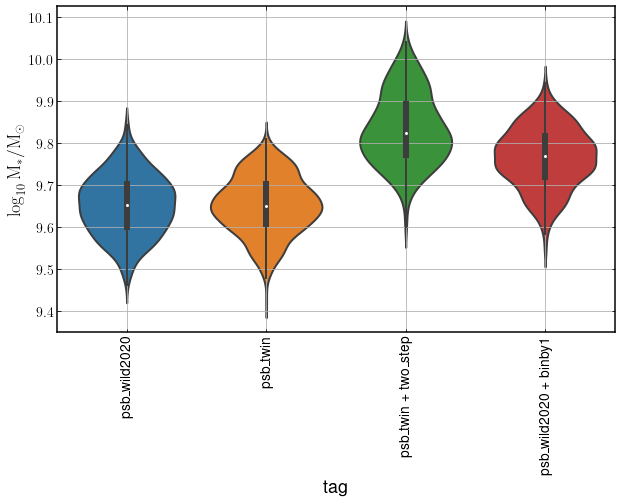

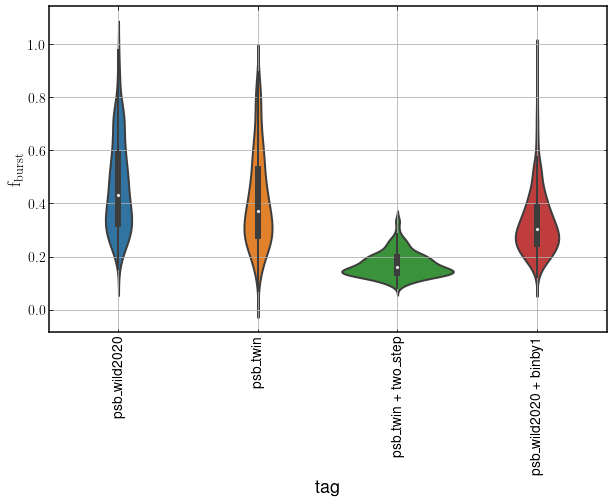

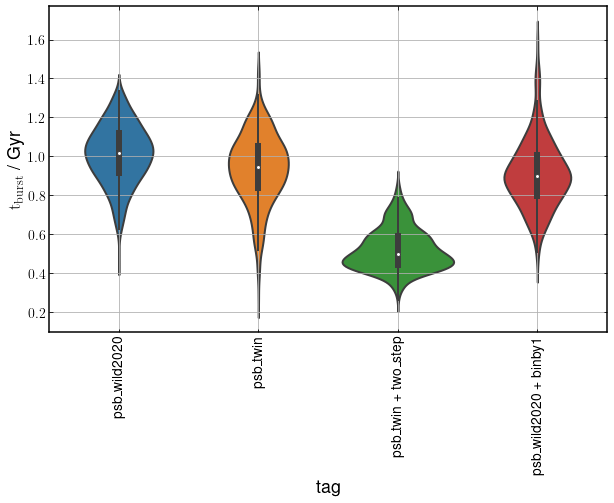

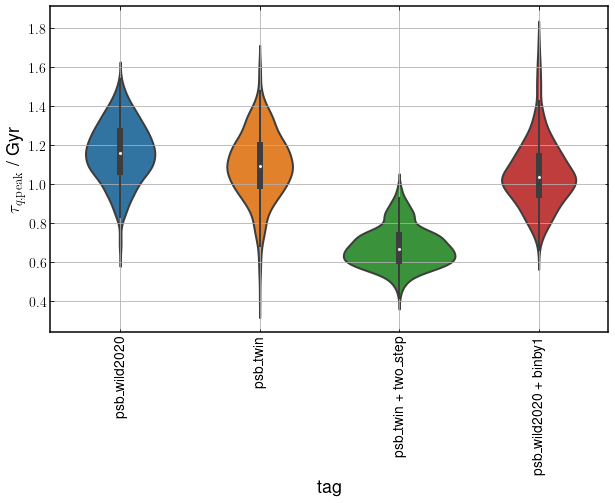

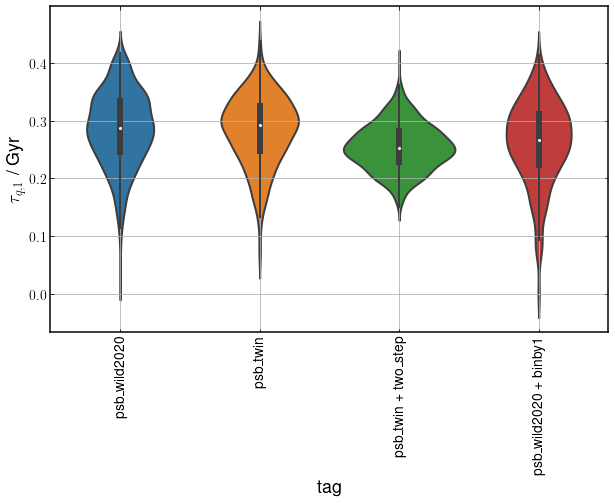

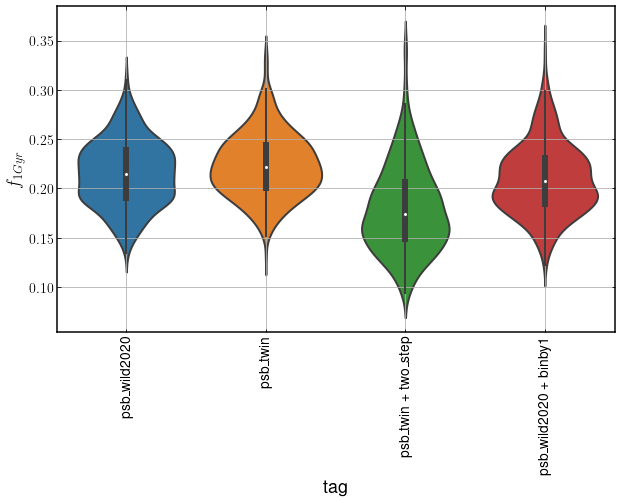

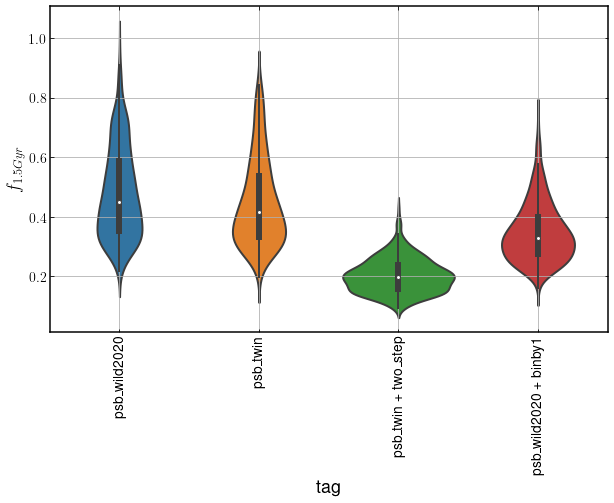

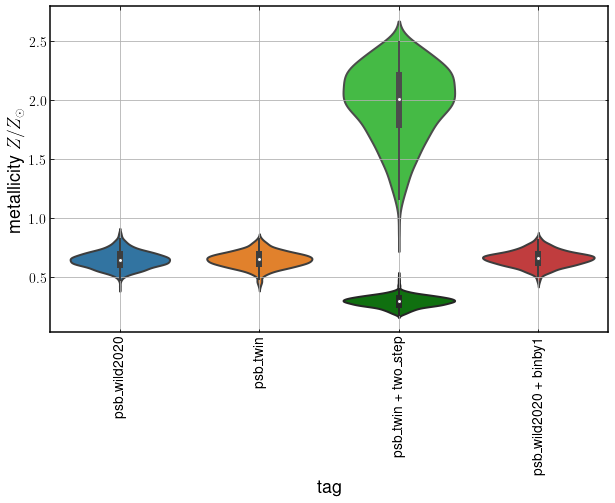

In [297]:
gal8083_12703_c.plot(['Mstar', 'f_burst', 't_burst', 'tquench_from_peak', 'tquench_from_1', 'f10', 'f15', 'zmet'],
                labels=['psb\\_wild2020', 'psb\\_twin', 'psb\\_twin + two\\_step', 'psb\\_wild2020 + binby1'])

runID = 9088-9102_datacube_summed_PSBonly_P1_no_red_phot_dereddened_binby3_Rspec4340

Results loaded from pipes/posterior/9088-9102_datacube_summed_PSBonly_P1_no_red_phot_dereddened_binby3_Rspec4340/9088-9102_PSBonly_dereddened.h5

posterior Mstar = [11.48952081 11.52795517 11.57132109]
posterior f_burst and t_burst: [0.10182522 0.14415046 0.21927405] [11.30141972 11.0628446  10.80229629]
posterior fractions =  [0.04421835 0.05497794 0.06950388] [0.11185583 0.13637549 0.17071787]
post tquench from peak =  [0.92372929 1.16039785 1.49792194]
post tquench from 1 =  [0.53242793 0.66700858 0.79656753]
posterior metallicity = [0.96734925 1.22865441 1.41477016]

********+++++++++=====divider=====+++++++++********

runID = 9088-9102_datacube_summed_PSBonly_P2_no_red_phot_dereddened_binby3_Rspec4340_psbtwin

Results loaded from pipes/posterior/9088-9102_datacube_summed_PSBonly_P2_no_red_phot_dereddened_binby3_Rspec4340_psbtwin/9088-9102_PSBonly_dereddened.h5

posterior Mstar = [11.47190457 11.5

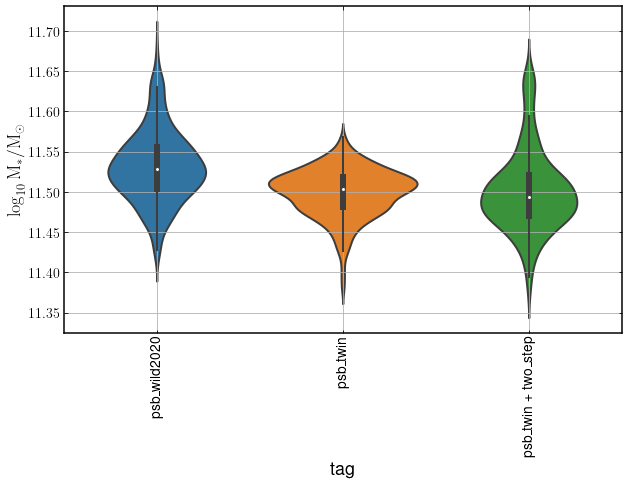

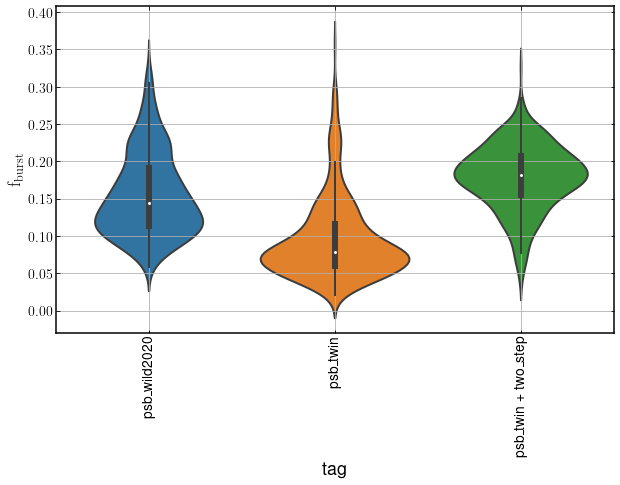

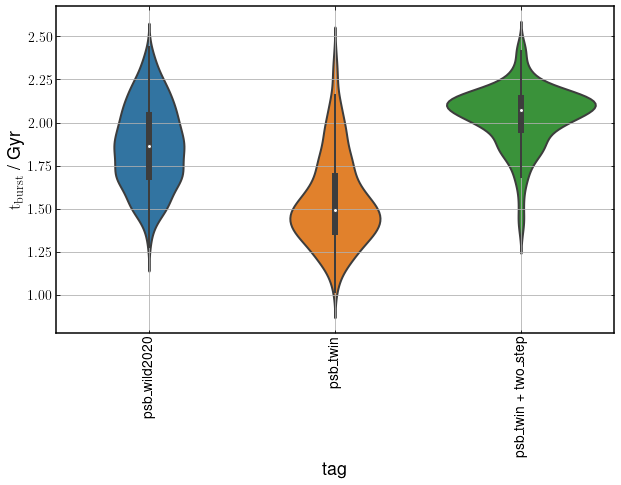

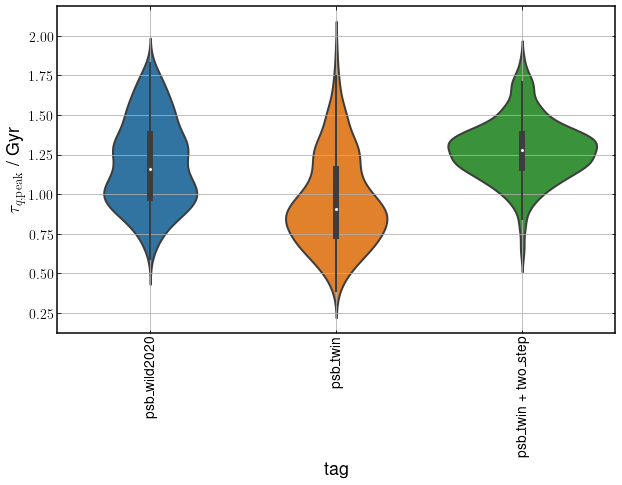

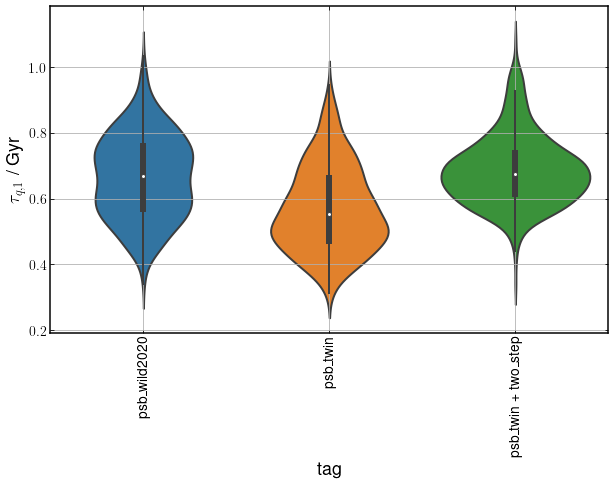

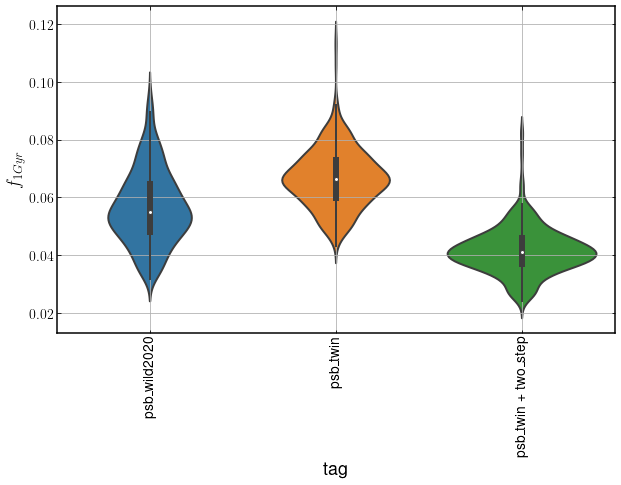

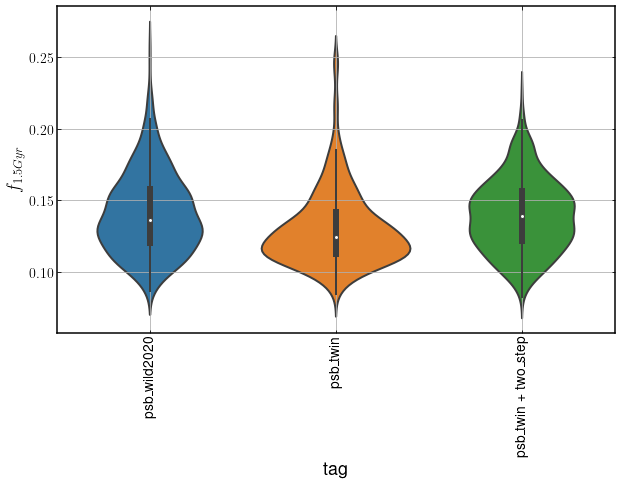

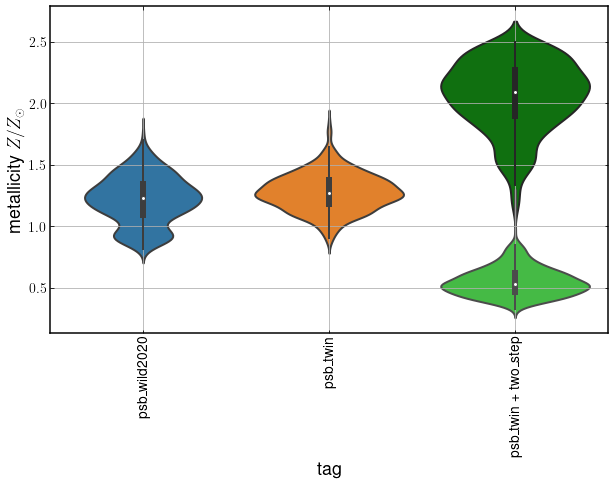

In [299]:
runID_cores = ['9088-9102_datacube_summed_PSBonly_P',
               '_no_red_phot_dereddened_binby3_Rspec4340']
gal9088_9102_c = comparison([runID_cores[0]+'1'+runID_cores[1], 
                              runID_cores[0]+'2'+runID_cores[1]+'_psbtwin', 
                              runID_cores[0]+'3'+runID_cores[1]+'_psbtwin_twostep'])

gal9088_9102_c.plot(['Mstar', 'f_burst', 't_burst', 'tquench_from_peak', 'tquench_from_1', 'f10', 'f15', 'zmet'],
                labels=['psb\\_wild2020', 'psb\\_twin', 'psb\\_twin + two\\_step'])

runID = 9507-12704_datacube_summed_PSBonly_P1_no_red_phot_dereddened_binby3_Rspec4340

Results loaded from pipes/posterior/9507-12704_datacube_summed_PSBonly_P1_no_red_phot_dereddened_binby3_Rspec4340/9507-12704_PSBonly_dereddened.h5

posterior Mstar = [10.56629902 10.58358907 10.61093932]
posterior f_burst and t_burst: [0.02312898 0.06587686 0.13226357] [13.06193114 12.86026752 12.55582116]
posterior fractions =  [0.16978826 0.18305863 0.19683643] [0.25161917 0.27863327 0.30151935]
post tquench from peak =  [0.38545681 0.85752273 1.99426231]
post tquench from 1 =  [0.         0.         0.04409367]
posterior metallicity = [0.73594138 0.76687728 0.79899353]

********+++++++++=====divider=====+++++++++********

runID = 9507-12704_datacube_summed_PSBonly_P2_no_red_phot_dereddened_binby3_Rspec4340_psbtwin

Results loaded from pipes/posterior/9507-12704_datacube_summed_PSBonly_P2_no_red_phot_dereddened_binby3_Rspec4340_psbtwin/9507-12704_PSBonly_dereddened.h5

posterior Mstar = [10.5722165

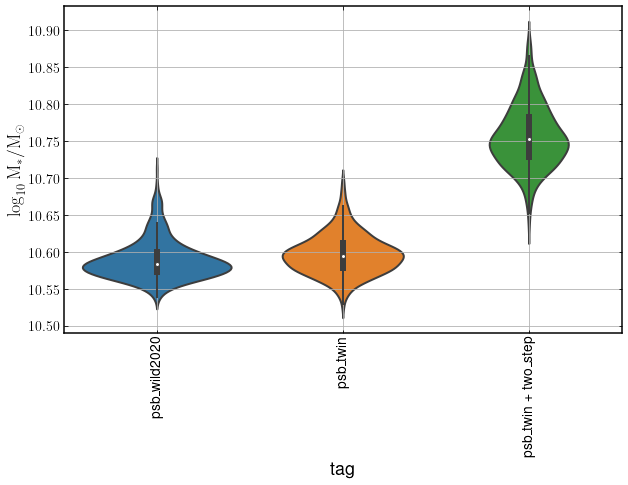

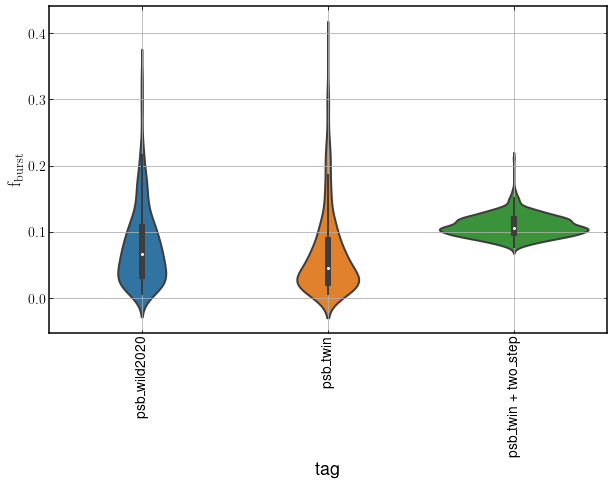

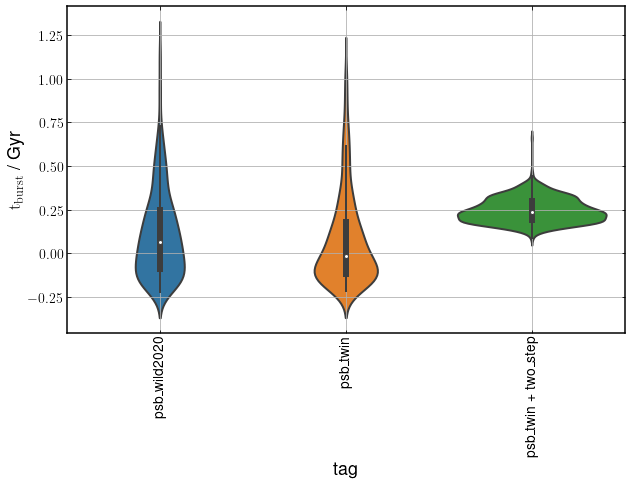

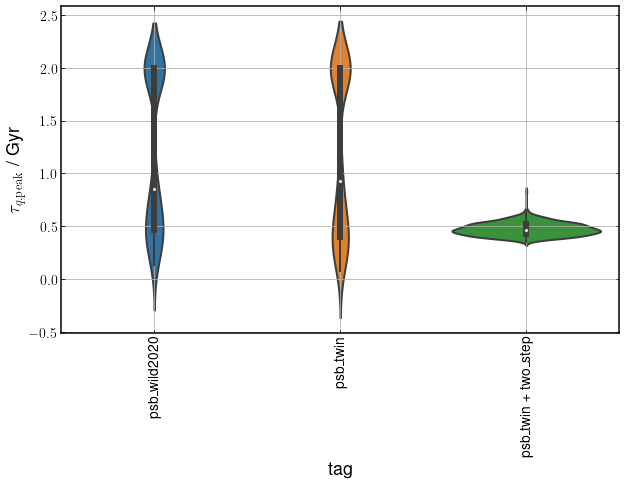

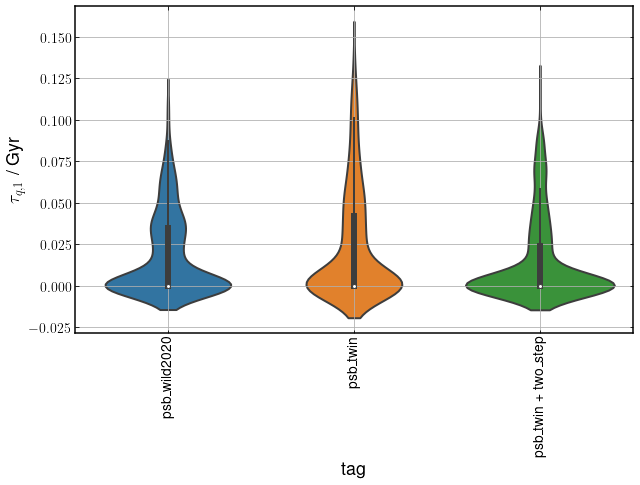

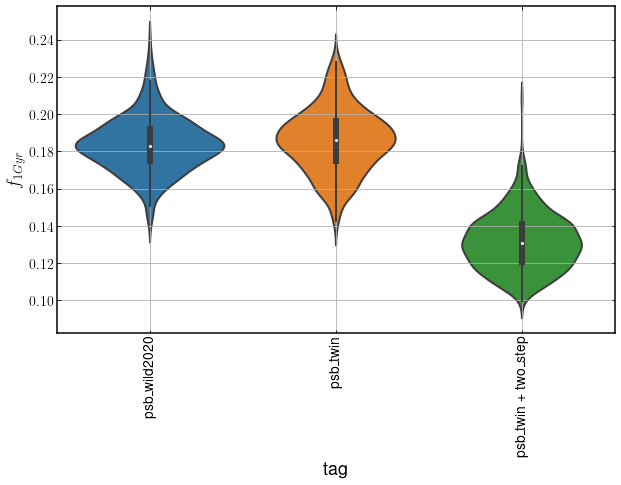

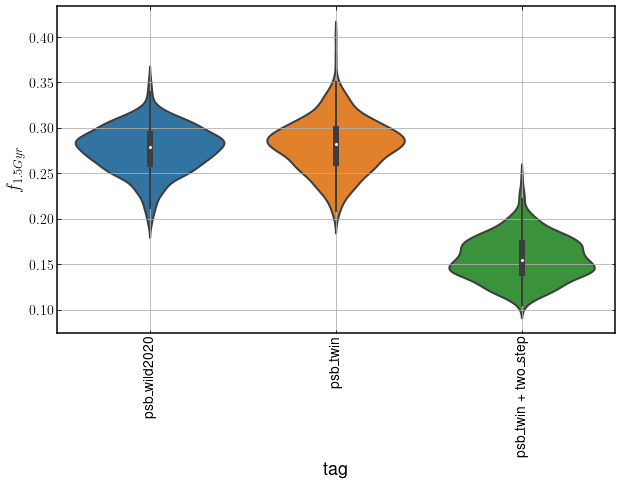

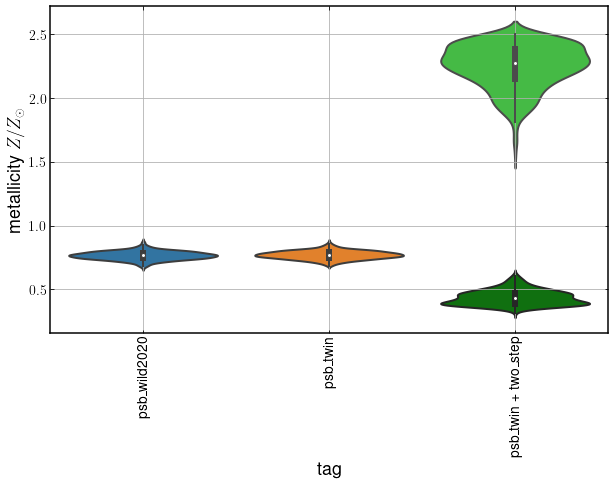

In [300]:
runID_cores = ['9507-12704_datacube_summed_PSBonly_P',
               '_no_red_phot_dereddened_binby3_Rspec4340']
gal9507_12704_c = comparison([runID_cores[0]+'1'+runID_cores[1], 
                              runID_cores[0]+'2'+runID_cores[1]+'_psbtwin', 
                              runID_cores[0]+'3'+runID_cores[1]+'_psbtwin_twostep'])

gal9507_12704_c.plot(['Mstar', 'f_burst', 't_burst', 'tquench_from_peak', 'tquench_from_1', 'f10', 'f15', 'zmet'],
                labels=['psb\\_wild2020', 'psb\\_twin', 'psb\\_twin + two\\_step'])